# 목차
1. 개발환경
2. 데이터셋<br>
    2-1. stanford_dogs 데이터셋 다운로드<br>
3. 모델 구성<br>
    3-1. CAM의 특징<br>
    3-2. 전처리: Normalizing, resizing<br>
4. CAM 구현하기<br>
5. Grad-CAM 구현하기<br>
    5-1. Grad_cam<br>
6. 바운딩 박스 구하기<br>
    6-1. 바운딩 박스 구하는 함수<br>
7. IOU 구하기<br>
    7-1. IOU는 교집합/합집합
8. 결과 비교<br>
    8-1. 원본 사진<br>
    8-2. CAM 성능<br>
    8-3. Grad-CAM 성능<br>
9. 회고

# 1. 개발환경

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. 데이터셋

## 2-1. stanford_dogs 데이터셋 다운로드

In [46]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 학습용 데이터셋

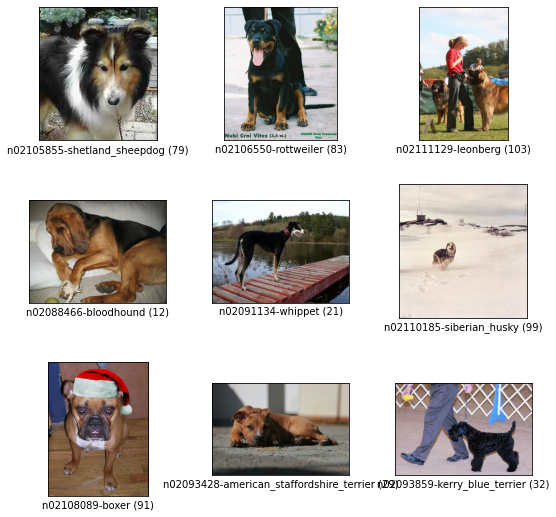

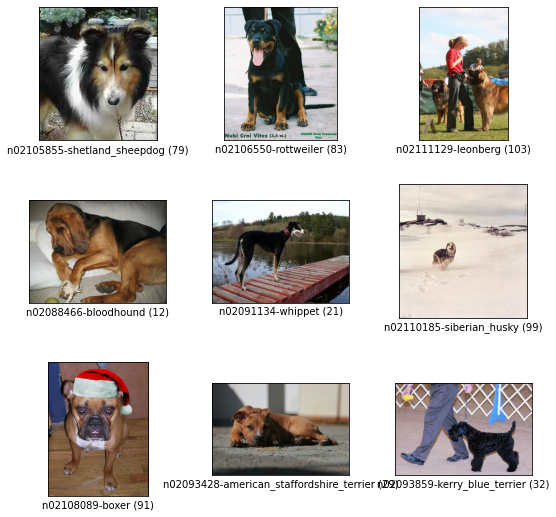

In [47]:
# tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인
tfds.show_examples(ds_train, ds_info)

### 훈련용 데이터셋

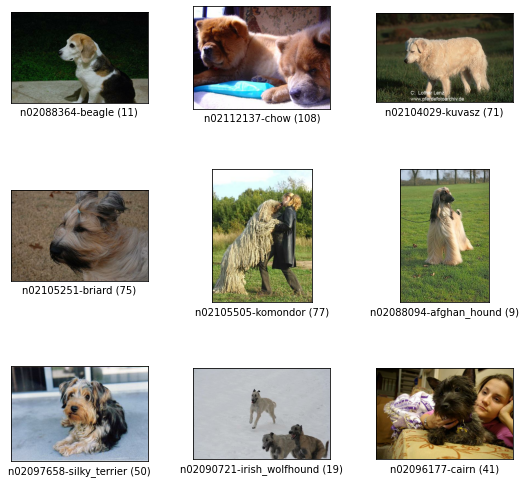

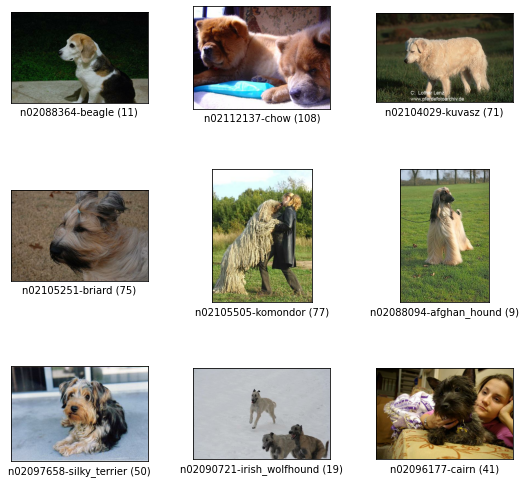

In [48]:
tfds.show_examples(ds_test, ds_info)

In [49]:
# 데이터셋의 메타 정보인 df_info를 조회
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

# 3. 모델 구성

### 3-1. CAM의 특징: 이미지넷 데이터로 훈련된 ResNet50 기반에, FCN 레이어가 아니라 GAP을 사용

In [50]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [51]:
cam_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### 3-2. 전처리: Normalizing, resizing 및 학습

In [52]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [53]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [54]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [55]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 165s 212ms/step - loss: 2.1806 - accuracy: 0.4538 - val_loss: 3.1651 - val_accuracy: 0.2429
Epoch 2/15
750/750 [==============================] - 157s 210ms/step - loss: 0.7724 - accuracy: 0.7837 - val_loss: 1.0896 - val_accuracy: 0.6785
Epoch 3/15
750/750 [==============================] - 157s 210ms/step - loss: 0.2499 - accuracy: 0.9447 - val_loss: 0.9562 - val_accuracy: 0.7212
Epoch 4/15
750/750 [==============================] - 157s 210ms/step - loss: 0.0927 - accuracy: 0.9883 - val_loss: 0.9254 - val_accuracy: 0.7291
Epoch 5/15
750/750 [==============================] - 157s 210ms/step - loss: 0.0485 - accuracy: 0.9953 - val_loss: 0.9044 - val_accuracy: 0.7467
Epoch 6/15
750/750 [==============================] - 157s 210ms/step - loss: 0.0221 - accuracy: 0.9982 - val_loss: 0.8801 - val_accuracy: 0.7535
Epoch 7/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0131 - accuracy: 0.9993 - val_loss: 0.8942 -

# 4. CAM 구현하기

In [56]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_modelqq.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [60]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


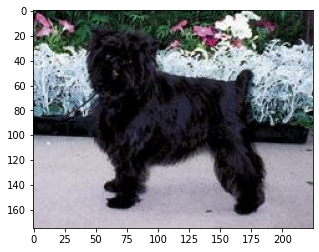

In [61]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [62]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [63]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

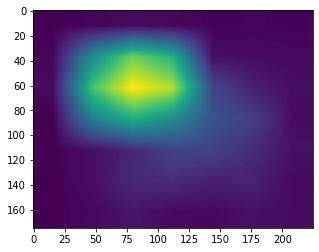

In [64]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [65]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

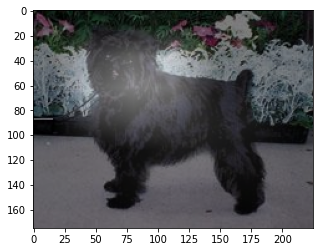

In [66]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# 5. Grad-CAM 구현하기

### 5-1. Grad_cam: 관찰하려는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구한 후, GAP 연산을 적용해 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.

80


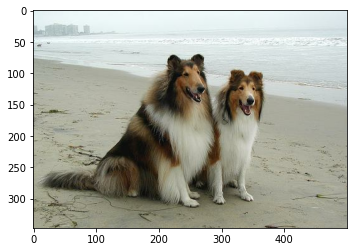

In [67]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [68]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

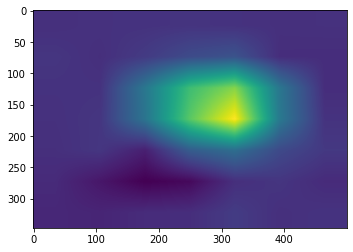

In [69]:
# 여러 레이어의 CAM 이미지를 뽑아서 직접 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

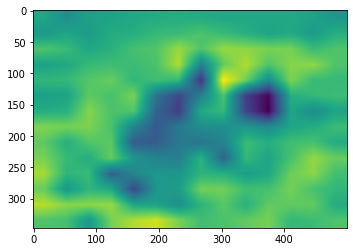

In [70]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

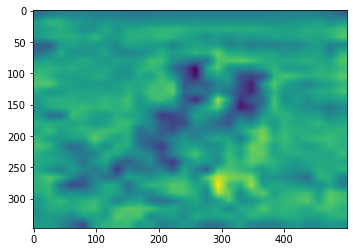

In [71]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

# 6. 바운딩 박스 구하기

100


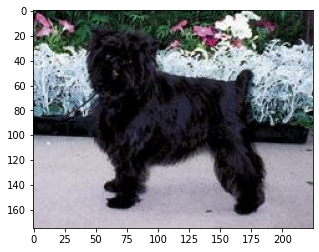

In [72]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

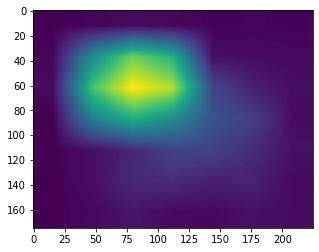

In [73]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

## 6-1. 바운딩 박스 구하는 함수

In [74]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [75]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 12,  17],
       [194,   0],
       [210, 161],
       [ 28, 179]])

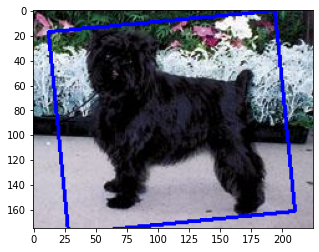

In [76]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [77]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), 
        rect[:,0].min()/float(image.shape[1]), 
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [78]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), 
        rect[:,0].min()/float(image.shape[1]), 
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [80]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [81]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.05333333333333334, 1.022857142857143, 0.9333333333333333]

# 7. IOU 구하기

### 7-1. IOU는 교집합/합집합

In [82]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [85]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6518819652698317

# 8. 결과 비교
## 8-1. 원본 사진

75


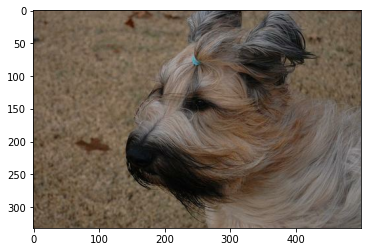

In [86]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

## 8-2. CAM 성능

In [87]:
cam_image = generate_cam(cam_model, item)

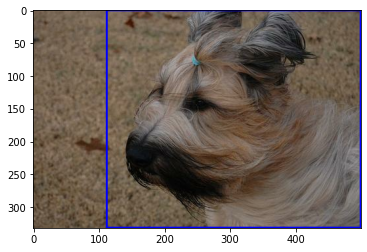

In [88]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [91]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.9276484689469637

## 8-3. Grad-CAM 성능

In [92]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)

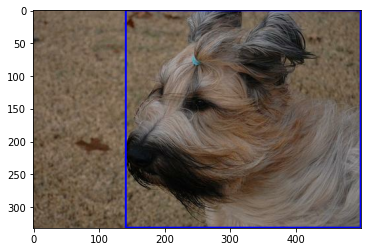

In [93]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect_g],0,(0,0,255),2)
plt.imshow(image)

In [96]:
pred_bbox = rect_to_minmax(rect_g, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.9972143618498451

# 9. 회고

Grad-Cam의 성능(0.997)이 Cam의 성능(0.928)보다 높게 나왔다. 바운딩 박스가 좀 더 디테일하게 설정된듯 하다. <br>
Cam 모델이 개를 식별할때 얼굴이 강조되었는데 사람이 개를 식별할 때 유의해서 보는 부분과 비슷하다. <br>
Grad-Cam은 개의 얼굴뿐 아니라 몸통까지 디테일하게 관찰할수 있다. 여러마리가 있어도 잘 구분한다. <br>
FCN 대신 GAP을 사용해 분류 파라미터 수가 감소해 연산 시간이 상당히 빨랐다고 느꼈다.